In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



In [67]:

# Paths
train_dir = "/kaggle/input/data-skin/skin burn dataset/train"
val_dir = "/kaggle/input/data-skin/skin burn dataset/valid"

# Parameters
batch_size = 32
img_height = 224
img_width = 224
num_classes = 4
epochs = 15 


In [68]:

# Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,  
    brightness_range=[0.6, 1.2],  
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [69]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4274 images belonging to 4 classes.
Found 583 images belonging to 4 classes.


In [70]:

# Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))


In [71]:
# Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  



In [72]:
# Adding the custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),  
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),  
    Dense(num_classes, activation='softmax')
])

In [73]:
# Learning Rate Scheduler: Exponential Decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=100000,
    decay_rate=0.9,
    staircase=True
)

In [74]:
# Compile the model with the learning rate schedule
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning EfficientNetB0 (unfreeze layers)
base_model.trainable = True  
fine_tune_at = 100  


In [75]:
# Freeze all layers up to 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model again after unfreezing layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weight_dict
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 121s 597ms/step - accuracy: 0.5463 - loss: 2.0950 - val_accuracy: 0.7770 - val_loss: 1.3022
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 56s 398ms/step - accuracy: 0.7660 - loss: 1.2887 - val_accuracy: 0.8079 - val_loss: 0.9711
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 409ms/step - accuracy: 0.8101 - loss: 0.9037 - val_accuracy: 0.8302 - val_loss: 0.8372
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 406ms/step - accuracy: 0.8348 - loss: 0.6732 - val_accuracy: 0.7667 - val_loss: 0.8543
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 401ms/step - accuracy: 0.8502 - loss: 0.5418 - val_accuracy: 0.8130 - val_loss: 0.6746
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 405ms/step - accuracy: 0.8679 - loss: 0.4604 - val_accuracy: 0.8250 - val_loss: 0.5653
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 403ms/step - accuracy: 0.8840 - loss: 0.3915 - val_accuracy: 0.7822 - val_loss: 0.8617
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.9003 - loss: 0.3455 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: 2nd degree burn
Confidence: 98.49%


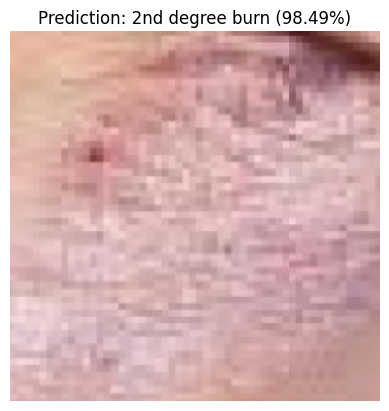

('2nd degree burn', 98.49270582199097)

In [76]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_image(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))  # Update to your model's input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Predict the class
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions, axis=1)
        class_labels = list(train_generator.class_indices.keys())
        predicted_class = class_labels[class_index[0]]
        confidence = predictions[0][class_index[0]] * 100  # Confidence in %

        # Print prediction and display image
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()

        return predicted_class, confidence
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Example usage
# Replace with your actual image path
image_path = '/kaggle/input/test-img/WhatsApp Image 2025-01-03 at 15.06.52_90eb22ab.jpg'
predict_image(image_path)


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Get the predicted labels and true labels
val_labels = val_generator.classes
val_preds = model.predict(val_generator, verbose=1)
val_preds = np.argmax(val_preds, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=train_generator.class_indices.keys()))



19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8160 - loss: 0.7663
Validation Loss: 0.8056638240814209
Validation Accuracy: 0.8061749339103699
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step
Classification Report:
                 precision    recall  f1-score   support

1st degree burn       0.24      0.20      0.22       154
2nd degree burn       0.30      0.31      0.31       195
3nd degree burn       0.10      0.16      0.12        50
   healthy skin       0.29      0.28      0.28       184

       accuracy                           0.26       583
      macro avg       0.23      0.24      0.23       583
   weighted avg       0.26      0.26      0.26       583



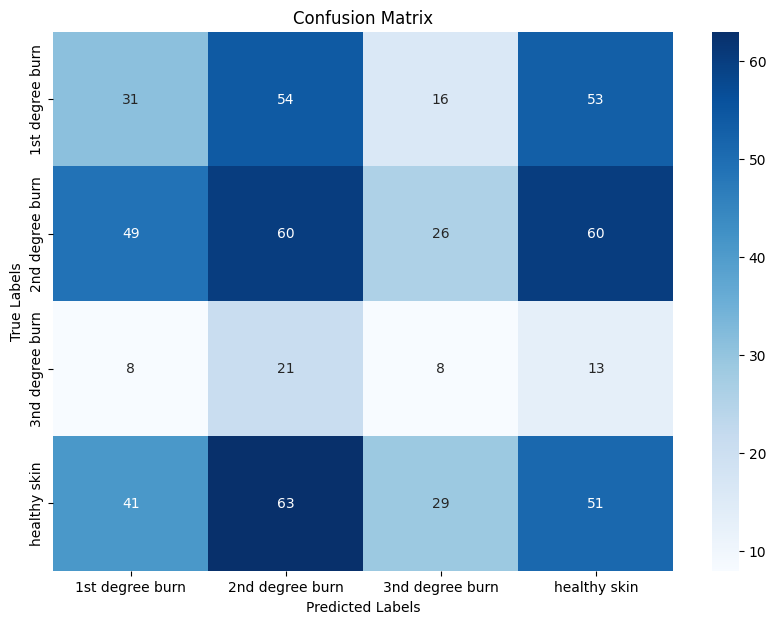

In [78]:
# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



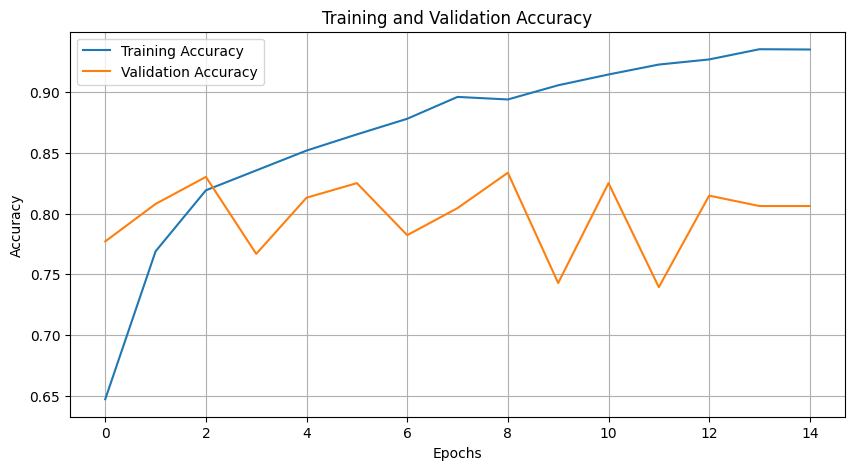

In [79]:
# Accuracy and Loss Graphs
history_dict = history.history

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


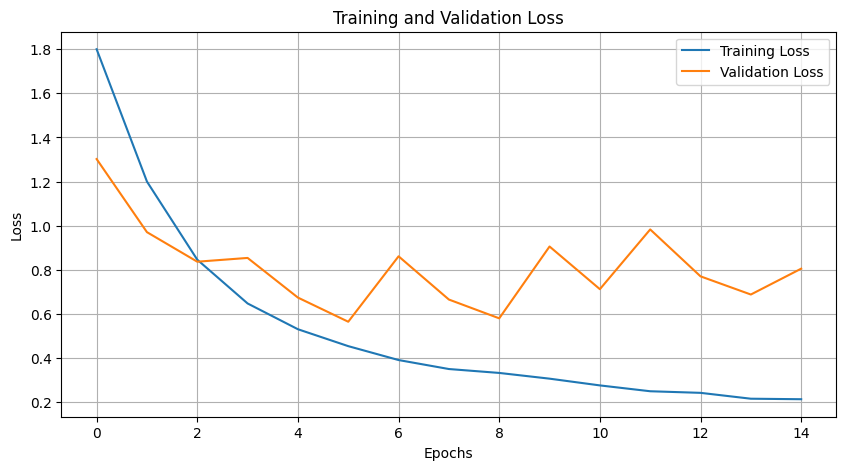

In [80]:

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Class: 2nd degree burn
Confidence: 98.11%


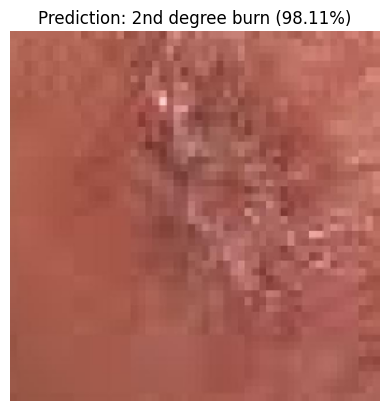

('2nd degree burn', 98.10582399368286)

In [82]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_image(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))  # Update to your model's input size
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Predict the class
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions, axis=1)
        class_labels = list(train_generator.class_indices.keys())
        predicted_class = class_labels[class_index[0]]
        confidence = predictions[0][class_index[0]] * 100  # Confidence in %

        # Print prediction and display image
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()
        return predicted_class, confidence
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Example usage
# Replace with your actual image path
image_path = "/kaggle/input/data-skin/skin burn dataset/test/img472_jpg.rf.1dae04bd44c2928995c5eca05268dad0.jpg"
predict_image(image_path)